# Imports

In [6]:
from pathlib import Path
from torchvision.datasets import ImageFolder
from argparse import Namespace
import torch
from torchvision import transforms
import random
from torch.utils.data import Subset
from diffusers import DDIMScheduler
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("bmh")

In [2]:
args = Namespace(
    train_data_dir="/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug",
    split="train",
    resolution=128,
    perc_samples=10,
    seed=42,
)

In [3]:
dataset: ImageFolder = ImageFolder(
    root=Path(args.train_data_dir, args.split).as_posix(),
    transform=lambda x: augmentations(x.convert("RGB")),
    target_transform=lambda y: torch.tensor(y).long(),
)

augmentations = transforms.Compose(
    [
        transforms.Resize(
            args.resolution, interpolation=transforms.InterpolationMode.BILINEAR
        ),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # map to [-1, 1] for SiLU
    ]
)

In [4]:
dataset

Dataset ImageFolder
    Number of datapoints: 3370
    Root location: /projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug/train
    StandardTransform
Transform: <function <lambda> at 0x7f9313d392d0>
Target transform: <function <lambda> at 0x7f9313d39480>

# Test

In [5]:
# 1. First test if the dataset is balanced; for now we assume it is
class_counts = dict.fromkeys([dataset.class_to_idx[cl] for cl in dataset.classes], 0)
for _, label in dataset.samples:
    class_counts[label] += 1

nb_classes = len(class_counts)

assert (
    list(class_counts.values()) == [class_counts[0]] * nb_classes
), "The dataset is not balanced between classes"

# 2. Then manually sample <perc_samples>% of each class
orig_nb_samples_per_balanced_classes = class_counts[0]

nb_selected_samples_per_class = int(
    orig_nb_samples_per_balanced_classes * args.perc_samples / 100
)

sample_indices = []

nb_selected_samples = dict.fromkeys(
    [dataset.class_to_idx[cl] for cl in dataset.classes], 0
)

# set seed
# `random` is only used here, for the dataset subsampling
random.seed(args.seed)

# random.sample(x, len(x)) shuffles x out-of-place
iterable = random.sample(list(enumerate(dataset.samples)), len(dataset))

for idx, (_, class_label) in iterable:
    # stop condition
    if (
        list(nb_selected_samples.values())
        == [nb_selected_samples_per_class] * nb_classes
    ):
        break
    # select sample
    if nb_selected_samples[class_label] < nb_selected_samples_per_class:
        sample_indices.append(idx)
        nb_selected_samples[class_label] += 1

assert (
    len(sample_indices) == nb_selected_samples_per_class * nb_classes
), "Something went wrong in the subsampling..."

# 3. Return the subset
subset = Subset(dataset, sample_indices)
# hacky but ok to do this because each class is present in the subset
subset.classes = dataset.classes


In [6]:
subset[0]


(tensor([[[ 0.2235,  0.0510,  0.1059,  ..., -0.9608, -0.9765, -0.9451],
          [ 0.3333,  0.1294,  0.1843,  ..., -0.9686, -0.9765, -0.9843],
          [ 0.1922,  0.1137,  0.0980,  ..., -0.9529, -0.9529, -0.9686],
          ...,
          [-0.9529, -0.9451, -0.9451,  ..., -0.9686, -0.9451, -0.9294],
          [-0.9843, -0.9451, -0.9294,  ..., -0.9216, -0.9451, -0.9451],
          [-0.9608, -0.9451, -0.9294,  ..., -0.9373, -0.9529, -0.9294]],
 
         [[-0.1137, -0.1373, -0.1451,  ..., -0.9922, -0.9922, -0.9922],
          [-0.1529, -0.1529, -0.1608,  ..., -0.9922, -0.9922, -1.0000],
          [-0.1529, -0.1294, -0.1216,  ..., -0.9922, -0.9922, -1.0000],
          ...,
          [-0.9843, -0.9765, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9843, -0.9843, -0.9922,  ..., -0.9922, -1.0000, -0.9922],
          [-0.9843, -0.9843, -0.9843,  ..., -0.9922, -0.9922, -0.9843]],
 
         [[ 0.1059,  0.0824,  0.1451,  ..., -0.9686, -0.9686, -0.9686],
          [ 0.0510,  0.0353,

In [7]:
subset[12]


(tensor([[[ 0.2941,  0.3804,  0.4353,  ..., -0.1294, -0.0275,  0.0980],
          [ 0.3412,  0.4588,  0.5922,  ..., -0.3176, -0.2784, -0.2941],
          [ 0.3882,  0.6000,  0.7882,  ..., -0.6314, -0.5451, -0.3961],
          ...,
          [-0.9529, -0.9373, -0.9373,  ..., -0.9529, -0.9451, -0.9294],
          [-0.9765, -1.0000, -0.9686,  ..., -0.9451, -0.9373, -0.9373],
          [-0.9529, -0.9686, -0.9922,  ..., -0.9216, -0.9451, -0.9373]],
 
         [[-0.0588, -0.0667, -0.0667,  ..., -0.7804, -0.7020, -0.6941],
          [-0.0588, -0.0588, -0.0588,  ..., -0.7647, -0.7255, -0.7647],
          [-0.0824, -0.0824, -0.0824,  ..., -0.7804, -0.7804, -0.8431],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9608, -0.9608, -0.9529],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9686, -0.9686, -0.9686],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9686, -0.9686, -0.9686]],
 
         [[ 0.3490,  0.2706,  0.1922,  ..., -0.9686, -0.9843, -0.9686],
          [ 0.3098,  0.1843,

In [8]:
classes = {0: 0, 1: 0}

for img in subset:
    classes[img[1].item()] += 1

classes

{0: 168, 1: 168}

In [9]:
type(subset[0])

tuple

In [10]:
dir(subset)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'classes',
 'dataset',
 'indices']

In [11]:
dataset.samples

[('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug/train/DMSO/Week10_40111_B02_1_113_1086.png',
  0),
 ('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug/train/DMSO/Week10_40111_B02_1_113_768.png',
  0),
 ('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug/train/DMSO/Week10_40111_B02_1_116_574.png',
  0),
 ('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug/train/DMSO/Week10_40111_B02_1_120_1031.png',
  0),
 ('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug/train/DMSO/Week10_40111_B02_1_124_615.png',
  0),
 ('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug/train/DMSO/Week10_40111_B02_1_133_233.png',
  0),
 ('/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug/train/DMSO/Week10_40111_B02_1_136_507.png',
  0),
 ('/project

In [12]:
dir(dataset)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_format_transform_repr',
 '_is_protocol',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'extensions',
 'extra_repr',
 'find_classes',
 'imgs',
 'loader',
 'make_dataset',
 'root',
 'samples',
 'target_transform',
 'targets',
 'transform',
 'transforms']

In [13]:
import numpy as np

In [14]:
subset.targets = [subset.dataset.targets[i] for i in subset.indices]

In [15]:
cl = 0
cl_idxes = np.nonzero(np.array(subset.targets) == cl)[0]
print(cl_idxes)

subsubset = Subset(subset, list(cl_idxes))
subsubset

[  1   2   4   5   6   7   9  13  16  17  18  19  20  23  25  31  34  36
  39  42  43  44  45  47  48  49  50  51  52  53  55  57  61  62  63  65
  68  70  72  73  75  77  78  79  80  85  86  87  88  89  91  95  98 101
 102 104 105 109 111 114 115 116 117 118 119 120 121 124 125 128 131 132
 134 138 143 144 145 146 149 151 152 153 155 159 160 161 165 167 170 174
 179 181 183 186 189 191 193 199 201 204 206 208 209 210 211 212 213 214
 217 220 224 225 229 230 234 239 241 242 245 249 250 251 252 253 254 257
 260 261 264 265 266 267 268 271 272 275 277 282 284 285 286 287 290 292
 295 299 300 301 303 304 305 306 310 312 315 316 319 320 323 324 325 326
 327 330 331 332 333 334]


In [16]:
len(subsubset)

168

In [17]:
len(dataset)

3370

In [18]:
len(subset)

336

In [19]:
args.perc_samples

10

In [20]:
raw_transformations = transforms.Compose(
    [
        transforms.Resize(
            args.resolution, interpolation=transforms.InterpolationMode.BILINEAR
        ),
        transforms.PILToTensor(),
    ]
)

from typing import Any, Callable, Optional
from torchvision.datasets import DatasetFolder
from PIL import Image
from torchvision.datasets.folder import default_loader


class RawDataset(ImageFolder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            sample
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        return sample


raw_dataset = RawDataset(
    root=Path(args.train_data_dir, args.split).as_posix(),
    transform=lambda x: raw_transformations(x.convert("RGB")),
)


In [21]:
raw_dataset


Dataset RawDataset
    Number of datapoints: 3370
    Root location: /projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug/train
    StandardTransform
Transform: <function <lambda> at 0x7f9313cc6cb0>

In [22]:
for x in raw_dataset:
    print(x)
    break


tensor([[[ 73,  74,  69,  ...,  29,  36,  51],
         [ 64,  65,  68,  ...,  62,  65,  81],
         [ 62,  63,  60,  ..., 112, 119, 135],
         ...,
         [ 80,  83,  84,  ...,  96,  98,  92],
         [ 76,  81,  82,  ...,  92,  89,  85],
         [ 85,  85,  83,  ...,  98,  92,  83]],

        [[ 61,  54,  59,  ...,   8,   8,  11],
         [ 59,  66,  66,  ...,  18,  15,  18],
         [ 69,  73,  66,  ...,  28,  19,  18],
         ...,
         [149, 150, 167,  ...,  56,  39,  43],
         [153, 164, 184,  ...,  53,  49,  49],
         [173, 181, 180,  ...,  36,  35,  43]],

        [[128, 145, 146,  ...,   6,   5,   4],
         [116, 133, 149,  ...,   7,   7,   4],
         [114, 117, 128,  ...,   4,   3,   4],
         ...,
         [ 10,   6,   5,  ...,   8,   7,   8],
         [  9,   7,   6,  ...,   5,   7,   6],
         [  9,  10,   7,  ...,   6,   2,   0]]], dtype=torch.uint8)


# Scheduler tests

In [23]:
noise_scheduler_config = {
    "_class_name": "DDIMScheduler",
    "_diffusers_version": "0.18.2",
    "beta_schedule": "scaled_linear",
    "beta_end": 0.015,
    "beta_start": 0.00001,
    "num_train_timesteps": 3000,
    "prediction_type": "v_prediction",
    "rescale_betas_zero_snr": True,
    "timestep_spacing": "trailing",
}


In [24]:
linear_config = noise_scheduler_config.copy()
linear_config["beta_schedule"] = "linear"

cosine_config = noise_scheduler_config.copy()
cosine_config["beta_schedule"] = "squaredcos_cap_v2"


In [25]:
nb_timesteps = 100


In [26]:
noise_scheduler = DDIMScheduler.from_config(noise_scheduler_config)


In [27]:
noise_scheduler.timesteps


tensor([2999, 2998, 2997,  ...,    2,    1,    0])

In [28]:
noise_scheduler.set_timesteps(nb_timesteps)
print(noise_scheduler.timesteps)

frac_diffusion_skipped = 0.7

init_timestep = noise_scheduler.config.num_train_timesteps * (
    1 - frac_diffusion_skipped
)
print(init_timestep)
# generation goes from T to 0, so we keep the timesteps *smaller* than init_timestep
timesteps = noise_scheduler.timesteps[noise_scheduler.timesteps <= init_timestep]
print(timesteps)

noise_scheduler = DDIMScheduler.from_config(noise_scheduler_config)

tensor([2999, 2969, 2939, 2909, 2879, 2849, 2819, 2789, 2759, 2729, 2699, 2669,
        2639, 2609, 2579, 2549, 2519, 2489, 2459, 2429, 2399, 2369, 2339, 2309,
        2279, 2249, 2219, 2189, 2159, 2129, 2099, 2069, 2039, 2009, 1979, 1949,
        1919, 1889, 1859, 1829, 1799, 1769, 1739, 1709, 1679, 1649, 1619, 1589,
        1559, 1529, 1499, 1469, 1439, 1409, 1379, 1349, 1319, 1289, 1259, 1229,
        1199, 1169, 1139, 1109, 1079, 1049, 1019,  989,  959,  929,  899,  869,
         839,  809,  779,  749,  719,  689,  659,  629,  599,  569,  539,  509,
         479,  449,  419,  389,  359,  329,  299,  269,  239,  209,  179,  149,
         119,   89,   59,   29])
900.0000000000001
tensor([899, 869, 839, 809, 779, 749, 719, 689, 659, 629, 599, 569, 539, 509,
        479, 449, 419, 389, 359, 329, 299, 269, 239, 209, 179, 149, 119,  89,
         59,  29])


In [29]:
noise_scheduler.alphas_cumprod[noise_scheduler.timesteps]


tensor([0.0000e+00, 1.1016e-11, 4.4370e-11,  ..., 9.9997e-01, 9.9998e-01,
        9.9999e-01])

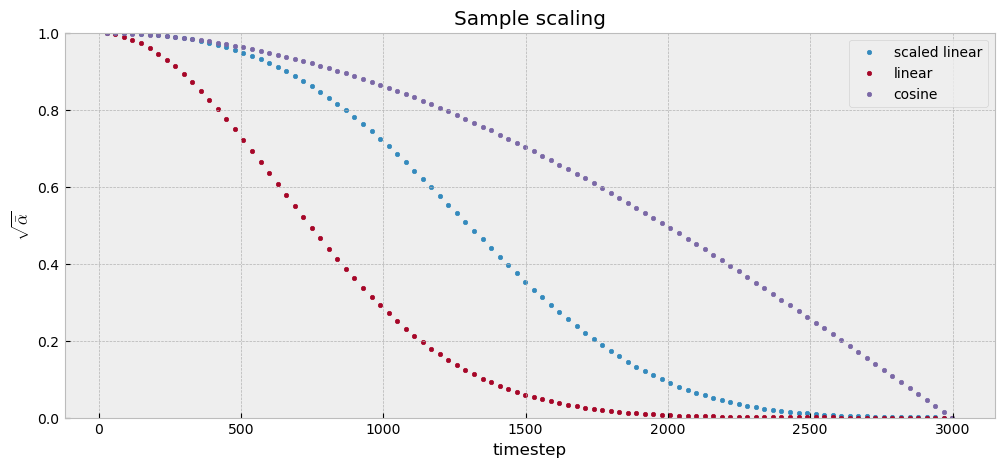

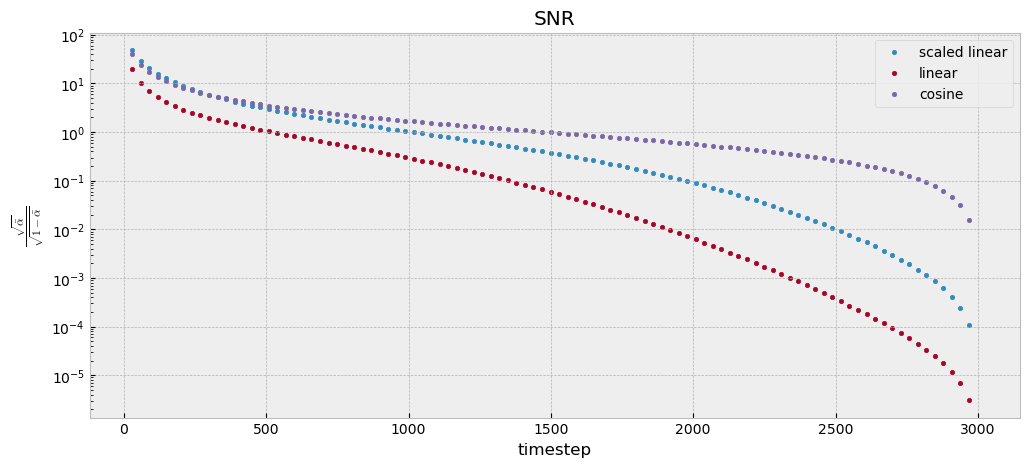

In [30]:
plt.figure(figsize=(12, 5))
for config in [noise_scheduler_config, linear_config, cosine_config]:
    noise_scheduler = DDIMScheduler.from_config(config)
    noise_scheduler.set_timesteps(nb_timesteps)
    plt.scatter(
        noise_scheduler.timesteps,
        np.sqrt(noise_scheduler.alphas_cumprod)[noise_scheduler.timesteps],
        10,
    )
plt.xlabel("timestep")
plt.legend(["scaled linear", "linear", "cosine"])
plt.ylabel(r"$\sqrt{\bar{\alpha}}$")
plt.ylim(0, 1)
plt.title("Sample scaling")
plt.show()

plt.figure(figsize=(12, 5))
for config in [noise_scheduler_config, linear_config, cosine_config]:
    noise_scheduler = DDIMScheduler.from_config(config)
    noise_scheduler.set_timesteps(nb_timesteps)
    plt.scatter(
        noise_scheduler.timesteps,
        np.sqrt(noise_scheduler.alphas_cumprod[noise_scheduler.timesteps])
        / np.sqrt(1 - noise_scheduler.alphas_cumprod[noise_scheduler.timesteps]),
        10,
    )
plt.xlabel("timestep")
plt.legend(["scaled linear", "linear", "cosine"])
plt.ylabel(r"$\frac{\sqrt{\bar{\alpha}}}{\sqrt{1 - \bar{\alpha}}}$")
plt.yscale("log")
plt.title("SNR")
plt.show()


# Dataset tests

In [31]:
from datasets import load_dataset
from torchvision import transforms
import torch
from torchvision.datasets import ImageFolder


In [32]:
torch_ds = ImageFolder(
    "/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug/train",
)


In [33]:
dataset = load_dataset(
    "imagefolder",
    data_dir="/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug",
    drop_labels=False,
    split="train",
)


Resolving data files:   0%|          | 0/6740 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/752 [00:00<?, ?it/s]

In [34]:
dataset


Dataset({
    features: ['image', 'label'],
    num_rows: 6740
})

In [35]:
torch_ds.classes


['DMSO', 'latrunculin_B_high_conc']

In [36]:
dataset.features["label"].names


['DMSO', 'latrunculin_B_high_conc']

In [37]:
dir(dataset)


['_TF_DATASET_REFS',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getitems__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_local_temp_path',
 '_check_index_is_initialized',
 '_data',
 '_estimate_nbytes',
 '_fingerprint',
 '_format_columns',
 '_format_kwargs',
 '_format_type',
 '_generate_tables_from_cache_file',
 '_generate_tables_from_shards',
 '_get_cache_file_path',
 '_get_output_signature',
 '_getitem',
 '_indexes',
 '_indices',
 '_info',
 '_map_single',
 '_new_dataset_with_indices',
 '_output_all_columns',
 '_push_parquet_shards_to_hub',
 '_save_to_disk_single',
 '_select_contiguous',
 '_select_with_indices_mappin

In [38]:
preproc = transforms.Compose(
    [
        transforms.Resize(
            128,
            interpolation=transforms.InterpolationMode.BILINEAR,
        ),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # map to [-1, 1] for SiLU
    ]
)


def transform_images(examples):
    images = [preproc(image.convert("RGB")) for image in examples["image"]]
    filenames_suffix = [
        image.filename.split("/")[-1].split(".")[0] for image in examples["image"]
    ]
    class_labels = torch.tensor(examples["label"]).long()
    return {
        "images": images,
        "filenames_suffix": filenames_suffix,
        "class_labels": class_labels,
    }


dataset.set_transform(transform_images)

In [39]:
next(iter(dataset))


{'images': tensor([[[-0.4275, -0.4196, -0.4588,  ..., -0.7725, -0.7176, -0.6000],
          [-0.4980, -0.4902, -0.4667,  ..., -0.5137, -0.4902, -0.3647],
          [-0.5137, -0.5059, -0.5294,  ..., -0.1216, -0.0667,  0.0588],
          ...,
          [-0.3725, -0.3490, -0.3412,  ..., -0.2471, -0.2314, -0.2784],
          [-0.4039, -0.3647, -0.3569,  ..., -0.2784, -0.3020, -0.3333],
          [-0.3333, -0.3333, -0.3490,  ..., -0.2314, -0.2784, -0.3490]],
 
         [[-0.5216, -0.5765, -0.5373,  ..., -0.9373, -0.9373, -0.9137],
          [-0.5373, -0.4824, -0.4824,  ..., -0.8588, -0.8824, -0.8588],
          [-0.4588, -0.4275, -0.4824,  ..., -0.7804, -0.8510, -0.8588],
          ...,
          [ 0.1686,  0.1765,  0.3098,  ..., -0.5608, -0.6941, -0.6627],
          [ 0.2000,  0.2863,  0.4431,  ..., -0.5843, -0.6157, -0.6157],
          [ 0.3569,  0.4196,  0.4118,  ..., -0.7176, -0.7255, -0.6627]],
 
         [[ 0.0039,  0.1373,  0.1451,  ..., -0.9529, -0.9608, -0.9686],
          [-0.0902

# CFG debug

In [40]:
%load_ext autoreload
%autoreload 3

In [41]:
from src.custom_pipeline_stable_diffusion_img2img import (
    CustomStableDiffusionImg2ImgPipeline,
)
from src.pipeline_conditional_ddim import ConditionalDDIMPipeline

from src.utils_Img2Img import load_datasets, print_grid, tensor_to_PIL
from omegaconf import DictConfig
import torch

In [42]:
device = "cuda:0"


In [43]:
DDIM_pipe = ConditionalDDIMPipeline.from_pretrained(
    "experiments/new_configs_test/full_pipeline_save", local_files_only=True
).to(device)

SD_pipe = CustomStableDiffusionImg2ImgPipeline.from_pretrained(
    "experiments/SD_100_perc/full_pipeline_save", local_files_only=True
).to(device)


In [44]:
cfg = {
    "dataset": {
        "BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug": {
            "_target_": "torchvision.datasets.ImageFolder",
            "root": "/projects/deepdevpath/Thomas/data/BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug",
            "resolution": 128,
            "normalize": [0.5, 0.5],
        }
    }
}


In [45]:
train_dataset, test_dataset = load_datasets(
    DictConfig(cfg), "BBBC021_comp_conc_nice_phen_high_conc_balanced_no_aug"
)

Resolving data files:   0%|          | 0/6740 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/752 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/6740 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/752 [00:00<?, ?it/s]

In [46]:
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
)

In [47]:
batch = next(iter(dataloader))
clean_images = batch["images"].to(device)
target_class_labels = 1 - batch["class_labels"].to(device)


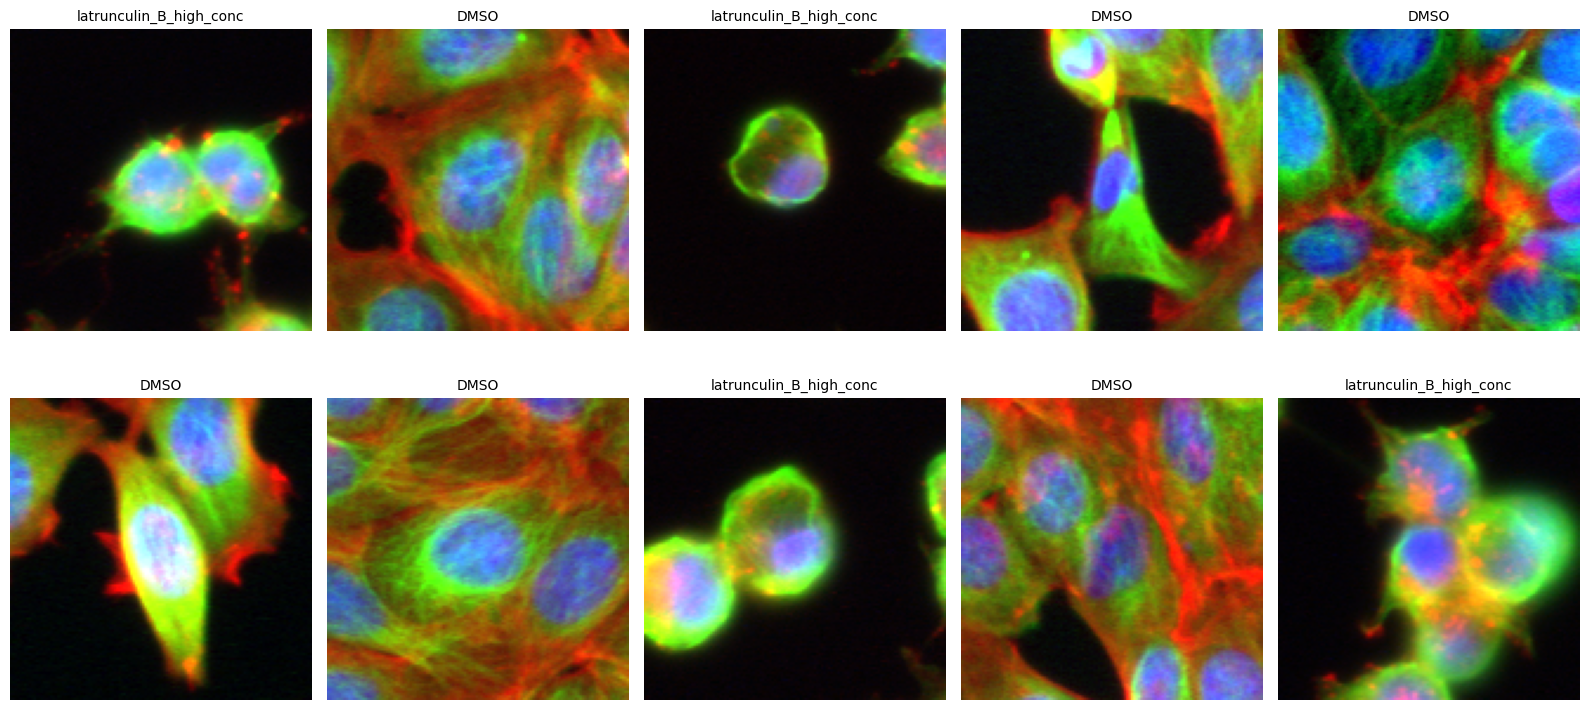

In [48]:
print_grid(
    tensor_to_PIL(clean_images[:10]),
    titles=[train_dataset.classes[i.item()] for i in batch["class_labels"][:10]],
)

In [52]:
num_inference_steps = 100
frac_diffusion_skipped = 0.3
guidance_scale = 4.5


  0%|          | 0/71 [00:00<?, ?it/s]

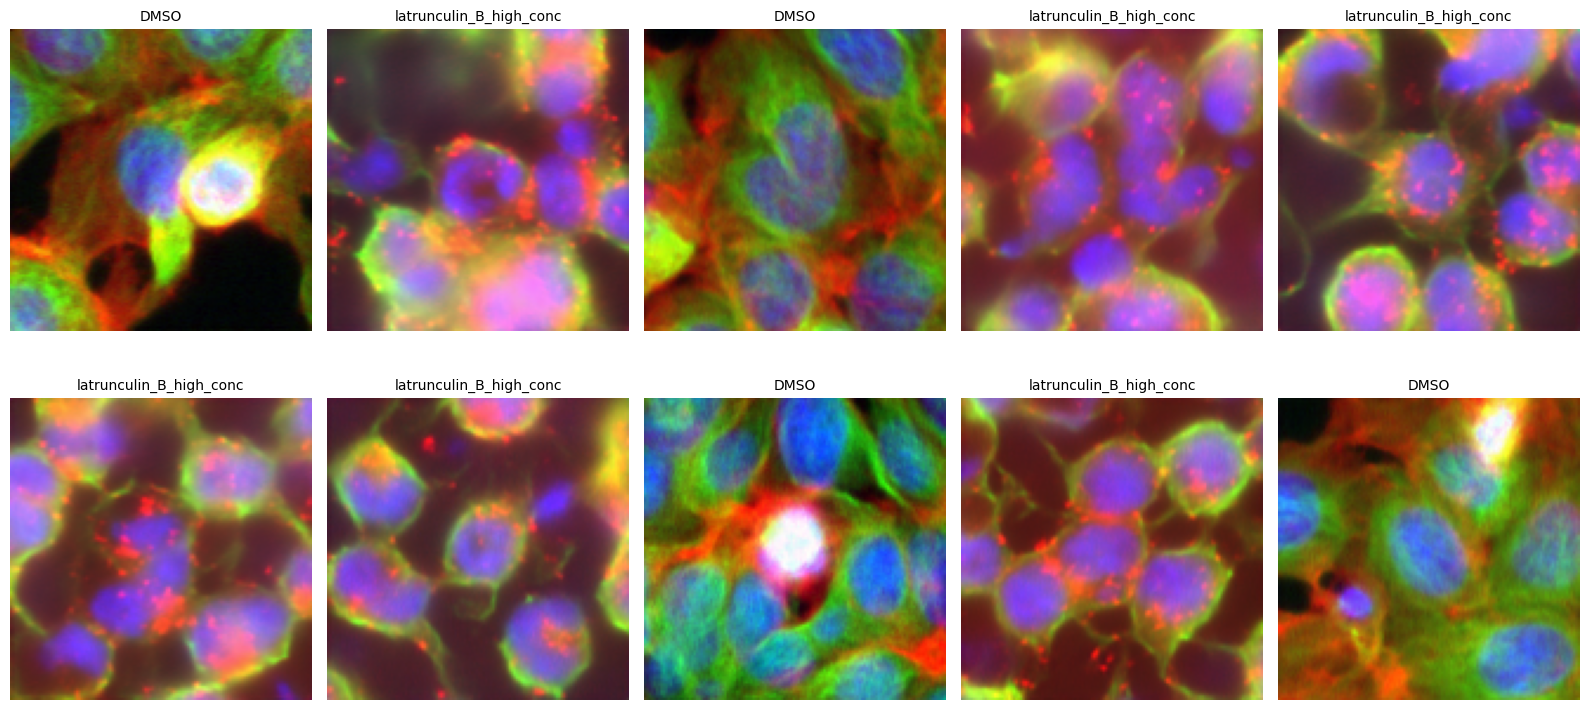

In [54]:
images_to_save = DDIM_pipe(
    class_labels=target_class_labels,
    w=guidance_scale,
    num_inference_steps=num_inference_steps,
    start_image=clean_images,
    frac_diffusion_skipped=frac_diffusion_skipped,
).images
print_grid(
    images_to_save[:10],
    titles=[train_dataset.classes[label.item()] for label in target_class_labels[:10]],
)

/users/biocomp/tboyer/micromamba/envs/diffusion-experiments/lib/python3.10/site-packages/diffusers/image_processor.py:203: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

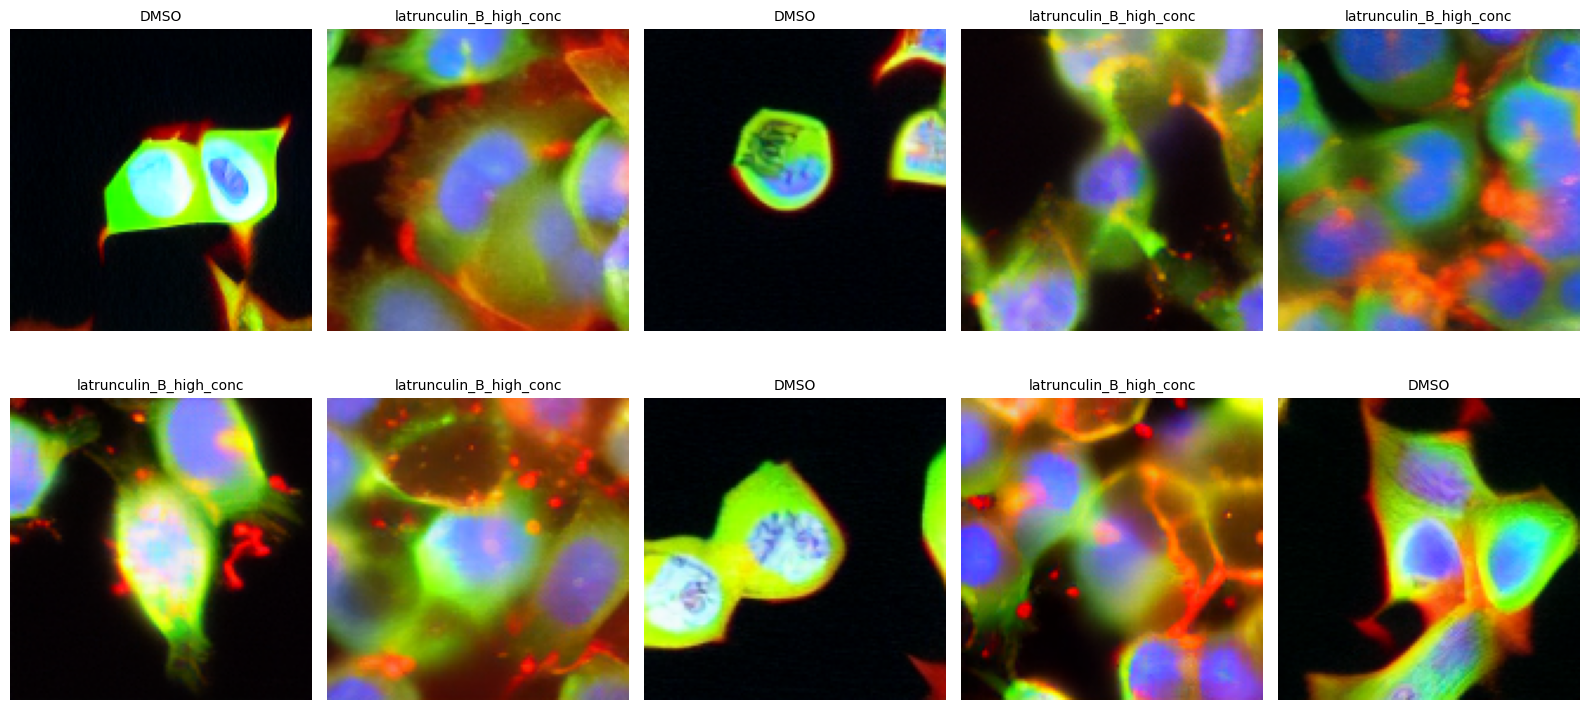

In [51]:
images_to_save = SD_pipe(
    image=clean_images,
    class_labels=target_class_labels,
    strength=frac_diffusion_skipped,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
)
print_grid(
    images_to_save[:10],
    titles=[train_dataset.classes[label.item()] for label in target_class_labels[:10]],
)

# Attention-fine-tuning

In [7]:
from src.pipeline_conditional_ddim import ConditionalDDIMPipeline
from diffusers.models.unet_2d_blocks import AttnDownBlock2D
from diffusers.models.attention_processor import AttnProcessor
from torchinfo import summary


In [8]:
DDIM_pipe = ConditionalDDIMPipeline.from_pretrained(
    "experiments/new_configs_test/full_pipeline_save", local_files_only=True
)
denoiser = DDIM_pipe.unet


In [9]:
print(denoiser.config)
print(f"{sum(p.numel() for p in denoiser.parameters()):,d} parameters")
print(
    f"{sum(p.numel() for p in denoiser.parameters() if p.requires_grad):,d} trainable parameters"
)

FrozenDict([('sample_size', 128), ('in_channels', 3), ('out_channels', 3), ('center_input_sample', False), ('time_embedding_type', 'positional'), ('freq_shift', 0), ('flip_sin_to_cos', True), ('down_block_types', ['DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D']), ('up_block_types', ['AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D']), ('block_out_channels', [128, 256, 512]), ('layers_per_block', 2), ('mid_block_scale_factor', 1), ('downsample_padding', 1), ('act_fn', 'silu'), ('attention_head_dim', 8), ('norm_num_groups', 32), ('norm_eps', 1e-05), ('resnet_time_scale_shift', 'default'), ('add_attention', True), ('class_embed_type', None), ('num_class_embeds', 2), ('_class_name', 'CustomCondUNet2DModel'), ('_diffusers_version', '0.18.2'), ('_name_or_path', 'experiments/new_configs_test/full_pipeline_save/unet')])
62,826,243 parameters
62,826,243 trainable parameters


In [10]:
summary(
    denoiser,
    input_size=(1, 3, 128, 128),
    timestep=torch.randint(
        0,
        100,
        (1,),
    ).long(),
    class_labels=torch.tensor([0] * 1).long(),
)


Layer (type:depth-idx)                        Output Shape              Param #
CustomCondUNet2DModel                         [1, 3, 128, 128]          --
├─Timesteps: 1-1                              [1, 128]                  --
├─TimestepEmbedding: 1-2                      [1, 512]                  --
│    └─Linear: 2-1                            [1, 512]                  66,048
│    └─SiLU: 2-2                              [1, 512]                  --
│    └─Linear: 2-3                            [1, 512]                  262,656
├─Embedding: 1-3                              [1, 512]                  1,024
├─Conv2d: 1-4                                 [1, 128, 128, 128]        3,584
├─ModuleList: 1-5                             --                        --
│    └─DownBlock2D: 2-4                       [1, 128, 64, 64]          --
│    │    └─ModuleList: 3-1                   --                        722,688
│    │    └─ModuleList: 3-2                   --                        147

In [11]:
_ = denoiser.requires_grad_(False)


In [12]:
print(f"{sum(p.numel() for p in denoiser.parameters()):,d} parameters")
print(
    f"{sum(p.numel() for p in denoiser.parameters() if p.requires_grad):,d} trainable parameters"
)

62,826,243 parameters
0 trainable parameters


In [13]:
summary(
    denoiser,
    input_size=(1, 3, 128, 128),
    timestep=torch.randint(
        0,
        100,
        (1,),
    ).long(),
    class_labels=torch.tensor([0] * 1).long(),
)


Layer (type:depth-idx)                        Output Shape              Param #
CustomCondUNet2DModel                         [1, 3, 128, 128]          --
├─Timesteps: 1-1                              [1, 128]                  --
├─TimestepEmbedding: 1-2                      [1, 512]                  --
│    └─Linear: 2-1                            [1, 512]                  (66,048)
│    └─SiLU: 2-2                              [1, 512]                  --
│    └─Linear: 2-3                            [1, 512]                  (262,656)
├─Embedding: 1-3                              [1, 512]                  (1,024)
├─Conv2d: 1-4                                 [1, 128, 128, 128]        (3,584)
├─ModuleList: 1-5                             --                        --
│    └─DownBlock2D: 2-4                       [1, 128, 64, 64]          --
│    │    └─ModuleList: 3-1                   --                        (722,688)
│    │    └─ModuleList: 3-2                   --                 

In [14]:
for module in denoiser.modules():
    if hasattr(module, "attentions"):
        print(
            f"Found 'attentions' attribute in {module.__class__.__name__}; setting requires_grad to True"
        )
        # for p in module.attentions.parameters():
        #     p.requires_grad_(True)
        module.attentions.requires_grad_(True)

Found 'attentions' attribute in AttnDownBlock2D; setting requires_grad to True
Found 'attentions' attribute in AttnUpBlock2D; setting requires_grad to True
Found 'attentions' attribute in UNetMidBlock2D; setting requires_grad to True


In [21]:
for component in DDIM_pipe.components.values():
    print(component.parameters())

<generator object Module.parameters at 0x7f84f6f40740>


AttributeError: 'DDIMScheduler' object has no attribute 'parameters'

In [ ]:
print(f"{sum(p.numel() for p in denoiser.parameters()):,d} parameters")
print(
    f"{sum(p.numel() for p in denoiser.parameters() if p.requires_grad):,d} trainable parameters"
)

62,826,243 parameters
6,309,888 trainable parameters


In [ ]:
summary(
    denoiser,
    input_size=(1, 3, 128, 128),
    timestep=torch.randint(
        0,
        100,
        (1,),
    ).long(),
    class_labels=torch.tensor([0] * 1).long(),
)


Layer (type:depth-idx)                        Output Shape              Param #
CustomCondUNet2DModel                         [1, 3, 128, 128]          --
├─Timesteps: 1-1                              [1, 128]                  --
├─TimestepEmbedding: 1-2                      [1, 512]                  --
│    └─Linear: 2-1                            [1, 512]                  (66,048)
│    └─SiLU: 2-2                              [1, 512]                  --
│    └─Linear: 2-3                            [1, 512]                  (262,656)
├─Embedding: 1-3                              [1, 512]                  (1,024)
├─Conv2d: 1-4                                 [1, 128, 128, 128]        (3,584)
├─ModuleList: 1-5                             --                        --
│    └─DownBlock2D: 2-4                       [1, 128, 64, 64]          --
│    │    └─ModuleList: 3-1                   --                        (722,688)
│    │    └─ModuleList: 3-2                   --                 